# PRE

In [170]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [171]:
name_project = 'stainless_steel'
bd.projects.set_current(name_project)

#Setting database

if 'ecoinvent-3.9.1-cutoff' in bd.databases:
    print('ecoinvent 3.9.1 is already present in the project')
else:
    bi.import_ecoinvent_release(
        version='3.9.1',
        system_model='cutoff', # can be cutoff / apos / consequential / EN15804
        username='precon6380',
        password='VpmJ4QB8Yn'
    )

ecoinvent 3.9.1 is already present in the project


# Lectura

In [172]:
# Iincluir aqui el path con los documento que contienen las actividades y los metodos de analises
path_act = r'C:\Users\sotoale\Documents\Python\activities_fondations.csv'
path_meth = r'C:\Users\sotoale\Documents\Python\methodes.csv'

In [173]:
df_activities = pd.read_csv(path_act, dtype={'activity_id': 'Int64'})
df_methods = pd.read_csv(path_meth)


In [174]:
df_activities

,variable,unit,location,activity_id,ecoinvent_name
0,acier_vierge_production,kilogram,RER,206853117766074370,"steel production, converter, low-alloyed"
1,beton_production,cubic meter,CH,206853180538028037,"market for concrete, normal strength"
2,acier_recycle_coule,kilogram,RER,206853134430044160,"steel production, electric, chromium steel 18/8"
3,acier_lamine,kilogram,RER,206853083444084737,"steel production, chromium steel 18/8, hot rolled"
4,nylon_production,kilogram,RER,206852950388178949,nylon 6-6 production
5,usinage_laser,hour,RER,206853189195071488,"laser machining, metal, with CO2-laser, 4000W ..."
6,use_engin_diesel,hour,GLO,206853116566503424,"machine operation, diesel, >= 18.64 kW and < 7..."
7,fret_voiture,kilometer,RER,206853213433954305,"transport, passenger car, EURO 5"
8,fret_camion,ton kilometer,RER,206853213945659392,"transport, freight, lorry 16-32 metric ton, EURO3"
9,fret_bateau,ton kilometer,GLO,206853170333286405,"transport, freight, sea, container ship"


In [175]:

#convierto las actividades en un diccionario

dic_activities = df_activities.set_index('variable').to_dict(orient='index')


#convierto los metodos en un lista de tuplas porque cuando para hacer la evaluation con multiLCA lo pide en ese formato
import ast

methods = df_methods['Method']  # Série pandas com strings de tuplas
listtupla = []

for element in methods:
    tupla = ast.literal_eval(element)  # converte string para tupla real
    listtupla.append(tupla)

listtupla

[('ecoinvent-3.9.1',
  'EF v3.1 EN15804',
  'climate change',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.9.1',
  'EF v3.1 EN15804',
  'material resources: metals/minerals',
  'abiotic depletion potential (ADP): elements (ultimate reserves)'),
 ('ecoinvent-3.9.1',
  'EF v3.1 EN15804',
  'energy resources: non-renewable',
  'abiotic depletion potential (ADP): fossil fuels'),
 ('ecoinvent-3.9.1',
  'EF v3.1 EN15804',
  'water use',
  'user deprivation potential (deprivation-weighted water consumption)'),
 ('ecoinvent-3.9.1',
  'EF v3.1 EN15804',
  'eutrophication: freshwater',
  'fraction of nutrients reaching freshwater end compartment (P)'),
 ('ecoinvent-3.9.1',
  'EF v3.1 EN15804',
  'ecotoxicity: freshwater',
  'comparative toxic unit for ecosystems (CTUe)')]

In [176]:
config = {
    "impact_categories": listtupla
}
config

def eval_impacts (functional_units,config,data_objs) :
    mlca = bc.MultiLCA(demands=functional_units, method_config=config, data_objs=data_objs)
    mlca.lci()
    mlca.lcia()
    return mlca.scores.values()

In [177]:
actividades = df_activities['variable']
categorias = df_methods['impact']
df_lca_u = pd.DataFrame(index=actividades, columns=categorias)
df_lca_u

for activity in actividades:
    functional_units = {
    activity:    {dic_activities[activity]['activity_id']: 1},
}
    data_objs = bd.get_multilca_data_objs(functional_units=functional_units, method_config=config) 
    impacts = list(eval_impacts(functional_units,config,data_objs))
    df_lca_u.loc[activity] = impacts

In [178]:
df_lca_u

impact,climate change,material resources,energy resource,water use,eutrophication: freshwater,ecotoxicity: freshwater
variable,,,,,,
acier_vierge_production,2.083503,0.000018,21.691453,0.57778,0.00101,7.487124
beton_production,225.759229,0.000808,965.740145,32.137103,0.025494,325.833025
acier_recycle_coule,4.65542,0.000126,53.639712,1.320114,0.001688,18.802537
acier_lamine,5.195869,0.000126,58.338104,1.672522,0.001789,20.891636
nylon_production,8.250567,0.000003,128.895954,9.726878,0.000441,8.559766
usinage_laser,25.186714,0.000466,550.047536,13.790072,0.023285,109.422296
use_engin_diesel,21.644672,0.000008,282.740996,0.699397,0.000658,134.169629
fret_voiture,0.343003,0.000004,4.542527,0.038443,0.000047,2.847714
fret_camion,0.188654,0.000001,2.710498,0.013215,0.000013,1.327848


# Evaluation total

In [179]:
df_lca = df_lca_u.T
df_lca
#verificar las actividades d'acir pq l'acier vierge est bcp moins polluteur que l'acier recyclé
#discutir se, acier laminé comptabilise déjà les impacts de l'acier coulé

variable,acier_vierge_production,beton_production,acier_recycle_coule,acier_lamine,nylon_production,usinage_laser,use_engin_diesel,fret_voiture,fret_camion,fret_bateau,fret_rail,fret_avion
impact,,,,,,,,,,,,
climate change,2.083503,225.759229,4.65542,5.195869,8.250567,25.186714,21.644672,0.343003,0.188654,0.010159,0.037885,0.794998
material resources,0.000018,0.000808,0.000126,0.000126,0.000003,0.000466,0.000008,0.000004,0.000001,0.0,0.0,0.0
energy resource,21.691453,965.740145,53.639712,58.338104,128.895954,550.047536,282.740996,4.542527,2.710498,0.125237,0.634971,10.622607
water use,0.57778,32.137103,1.320114,1.672522,9.726878,13.790072,0.699397,0.038443,0.013215,0.000353,0.014118,0.014456
eutrophication: freshwater,0.00101,0.025494,0.001688,0.001789,0.000441,0.023285,0.000658,0.000047,0.000013,0.0,0.000022,0.000011
ecotoxicity: freshwater,7.487124,325.833025,18.802537,20.891636,8.559766,109.422296,134.169629,2.847714,1.327848,0.061423,0.214743,5.15532


In [180]:
act = bd.get_activity(dic_activities['acier_recycle_coule']['activity_id'])
act

for exc in act.exchanges():
    print(exc['amount'], exc['unit'], exc.input)

print("Descripción:", act.get('product_information'))

information = act.as_dict()
#print(infomation)

for clave, valor in information.items():
    print(f"{clave}: {valor}")

1.0 kilogram 'steel production, electric, chromium steel 18/8' (kilogram, RER, None)
0.004 kilogram 'market for anode, for metal electrolysis' (kilogram, GLO, None)
0.032 kilogram 'market for argon, liquid' (kilogram, RER, None)
4e-11 unit 'market for electric arc furnace converter' (unit, GLO, None)
-0.0191274 kilogram 'market for electric arc furnace dust' (kilogram, RER, None)
-0.01924 kilogram 'market for electric arc furnace secondary metallurgy slag' (kilogram, RER, None)
-0.145866 kilogram 'market for electric arc furnace slag' (kilogram, RER, None)
0.625 kilowatt hour 'market group for electricity, medium voltage' (kilowatt hour, RER, None)
0.26471 kilogram 'market for ferrochromium, high-carbon, 68% Cr' (kilogram, GLO, None)
0.32 kilogram 'market for ferronickel' (kilogram, GLO, None)
0.00916515138991168 kilogram 'market for hard coal' (kilogram, Europe, without Russia and Turkey, None)
-0.00678233 kilogram 'market for inert waste, for final disposal' (kilogram, CH, None)
0.55

In [181]:
production = {
    #'acier_recycle_coule': 4000 , # kg d'acier
    'acier_lamine': 4000 ,        # kg d'acier   
    'nylon_production': 12 ,     # kg de nylon
    'fret_camion' : 3244 ,      # tonnes*km
    'usinage_laser' : 24         # heures d'usage 
}

productionV = {
    'acier_recycle_coule': 400 ,
    'acier_lamine': 350 ,
    'nylon_production': 50 ,
    'usinage_laser' : 10

}

construction = {
    'fret_camion': 939 ,        # tonne*km
    'fret_camion': 600,          # tonne*km
    #'fret_voiture': 350 ,       # km
    'use_engin_diesel': 2      # heures d'usage 
}

FdV = {
    'fret_camion': 2169 + 600 ,        # tonne*km
    #'fret_voiture': 350 ,       # km
    'use_engin_diesel': 2      # heures d'usage 
}


In [182]:
t_cha = df_lca['fret_camion']
t_cha

impact
climate change                0.188654
material resources            0.000001
energy resource               2.710498
water use                     0.013215
eutrophication: freshwater    0.000013
ecotoxicity: freshwater       1.327848
Name: fret_camion, dtype: object

In [183]:
df_lca_prod =  pd.DataFrame(index = production.keys(), columns=categorias)
df_lca_prod

impact,climate change,material resources,energy resource,water use,eutrophication: freshwater,ecotoxicity: freshwater
acier_lamine,NaN,NaN,NaN,NaN,NaN,NaN
nylon_production,NaN,NaN,NaN,NaN,NaN,NaN
fret_camion,NaN,NaN,NaN,NaN,NaN,NaN
usinage_laser,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
df_lca_prod =  pd.DataFrame(index = production.keys(), columns=categorias)
for key in production.keys():
    total_impact = df_lca_u.loc[key].values * production[key]
    df_lca_prod.loc[key] = total_impact

df_lca_cons =  pd.DataFrame(index = construction.keys(), columns=categorias)
for key in construction.keys():
    total_impact = df_lca_u.loc[key].values * construction[key]
    df_lca_cons.loc[key] = total_impact

df_lca_FdV =  pd.DataFrame(index = FdV.keys(), columns=categorias)
for key in construction.keys():
    total_impact = df_lca_u.loc[key].values * FdV[key]
    df_lca_FdV.loc[key] = total_impact

In [185]:
def graph_normalizados(tabla):
    """
    Genera un gráfico de barras apiladas mostrando la fracción de cada actividad
    dentro del total de cada impacto (normalización por columnas).
    
    Parámetros:
        tabla (pd.DataFrame): DataFrame con actividades como índices y los impactos como columnas.
    """
    
    # Normalizar por columnas (impactos)
    df_frac = tabla.div(tabla.sum(axis=0), axis=1)
    
    # Calcular totales para mostrar sobre las barras
    impact_totals = tabla.sum(axis=0)
    print("Totales por impacto:\n", impact_totals.map(lambda x: f"{x:.2e}"))

    # Transponer para que los impactos estén en el eje X
    df_frac = df_frac.T    

    # Graficar
    ax = df_frac.plot(kind='bar', stacked=True, colormap='viridis', figsize=(8, 6))

      # Agregar totales encima de cada barra
    for idx, total in enumerate(impact_totals):
        ax.text(idx, 1.02, f'{total:.2e}', ha='center', va='bottom', fontsize=7, fontweight='bold')

    # Estética
    plt.title('Fraction des impacts par activité')
    plt.ylabel("Fraction de l'impact total")
    plt.xlabel('Impact')
    plt.ylim(0, 1.1)
    plt.legend(title='Activité', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



# Graphiques

## Etape par etape

Totales por impacto:
 impact
climate change                2.21e+04
material resources            5.18e-01
energy resource               2.57e+05
water use                     7.18e+03
eutrophication: freshwater    7.76e+00
ecotoxicity: freshwater       9.06e+04
dtype: object


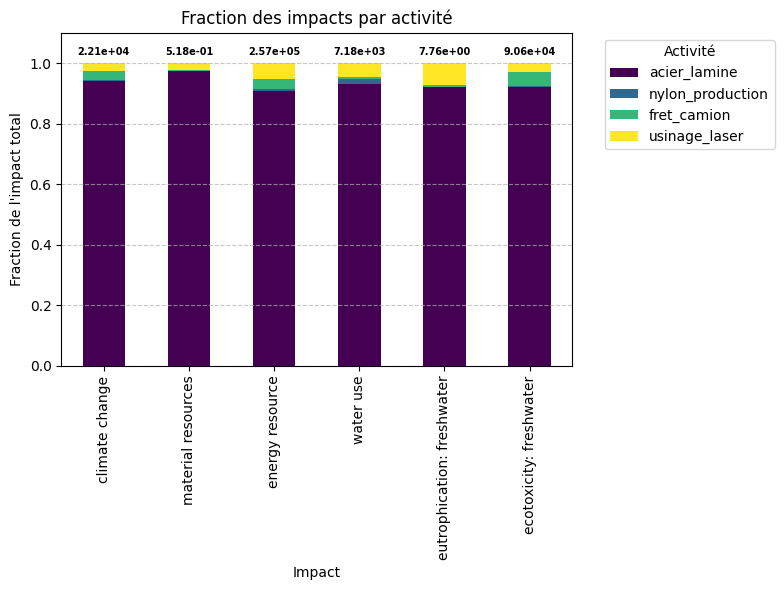

In [186]:
# Cette fonction permet d'obtenir en détail l'impact environnemental de chaque activité pour une étape spécifique.
# Il suffit de modifier l'argument de la fonction en passant le tableau correspondant à l'étape que vous souhaitez analyser.

etape = graph_normalizados(df_lca_prod)

## toutes les activités sans distingtion d'etape

Totales por impacto:
 impact
climate change                2.28e+04
material resources            5.20e-01
energy resource               2.67e+05
water use                     7.23e+03
eutrophication: freshwater    7.81e+00
ecotoxicity: freshwater       9.56e+04
dtype: object


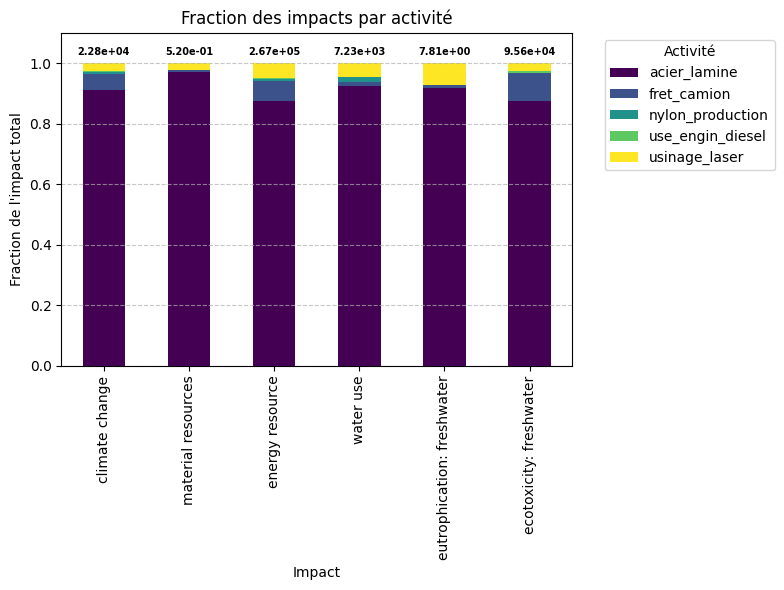

In [187]:
df_sum = pd.concat([df_lca_prod,df_lca_cons, df_lca_FdV])
df_grup = df_sum.groupby(df_sum.index).sum(numeric_only=False)
df_grup

graph_normalizados(df_grup)

## Tout le cycle de vie par etape

Totales por impacto:
 impact
climate change                2.28e+04
material resources            5.20e-01
energy resource               2.67e+05
water use                     7.23e+03
eutrophication: freshwater    7.81e+00
ecotoxicity: freshwater       9.56e+04
dtype: object


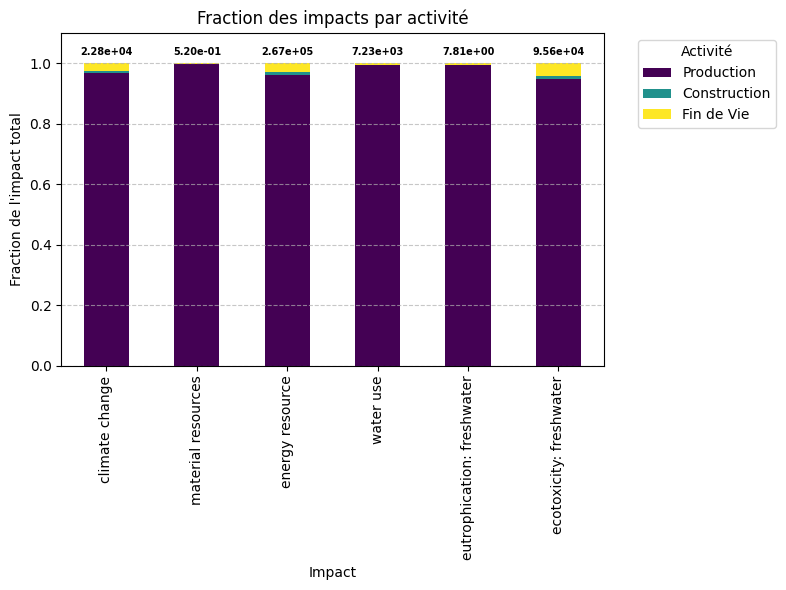

In [188]:
etapes = ['Production', 'Construction','Fin de Vie']
prod = df_lca_prod.sum()
cons = df_lca_cons.sum()
FdV = df_lca_FdV.sum()

df_etape = pd.DataFrame(index = etapes, columns=categorias)
df_etape.loc['Production'] = prod
df_etape.loc['Construction'] = cons
df_etape.loc['Fin de Vie'] = FdV


df_etape
graph_normalizados(df_etape)

In [189]:
df_complet = pd.concat([df_lca_prod,df_lca_cons, df_lca_FdV], keys = ['production','construction','FdV'])
